Importing some useful Packages


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

<h3> Extracting The Dataset

I have used a Traffic Sign Detection dataset containing images of 4 categories : Traffic Lights , Stop signs, Speedlimit signs and Pedestrian Crossing signs. *It can be downloaded from :* {https://makeml.app/datasets/road-signs}

I will be changing the dataset format to 4 folders belonging to the 4 classes, each folder constituting the respective images


In [ ]:
import xml.etree.ElementTree as ET
from PIL import Image

for i in range(877):
  img_path = "images/road"+str(i)+".png"
  img = Image.open(img_path)
  
  # Set the path to the XML file you want to read
  xml_path = "annotations/road"+str(i)+".xml"

  # Parse the XML file into an ElementTree object
  tree = ET.parse(xml_path)

  # Get the root element of the XML file
  root = tree.getroot()

  # Accessing the data in the XML file
  # category stores the class of the image
  category = root.find(".//object/name").text
  # Below are the dimensions provided of the bounding box
  xmin = int(root.find(".//object/bndbox/xmin").text)
  ymin = int(root.find(".//object/bndbox/ymin").text)
  xmax = int(root.find(".//object/bndbox/xmax").text)
  ymax = int(root.find(".//object/bndbox/ymax").text)

  bndbox = (xmin,ymin,xmax,ymax)
  img = img.crop(bndbox)    # Cropping the image w.r.t boundbox
  img = img.resize((300,400)) # Resizing image to the original size of the dataset

  dest_path = "dataset/"
  if category == "trafficlight": dest_path += "Traffic_Light"
  elif category == 'stop' : dest_path += "Stop"
  elif category == 'speedlimit' : dest_path += "Speedlimit"
  elif category == 'crosswalk' : dest_path += "Pedestrian"
  
  dest_path += "/road"+ str(i) + ".png" 
  img.save(dest_path)
  # shutil.move(img_path,dest_path)

In [84]:
import pathlib
dataset_path = "dataset/"
data_dir = pathlib.Path(dataset_path)

print("Total images in the dataset : ",len(list(data_dir.glob('*/*.png'))))

Total images in the dataset :  877


(300, 400)


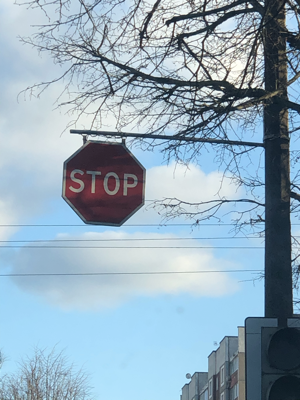

In [98]:
import random
sample_image = 'original_dataset/images/road'+str(random.randint(0,877))+'.png'
# Displaying a random image from the original dataset before Image Tiling
sample_image = PIL.Image.open(sample_image)   
sample_image


In [100]:
# Getting the dimensions of an image of this dataset
img_height, img_width = sample_image.size
batch_size = 16
print(sample_image.size)

(300, 400)


Loading this dataset

In [101]:
# Setting up training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # Validation/Train ratio is set to 0.2
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 877 files belonging to 4 classes.
Using 702 files for training.


In [102]:
# Setting up Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 877 files belonging to 4 classes.
Using 175 files for validation.


In [103]:
# Extracting labels
class_names = train_ds.class_names
print(class_names)

['Pedestrian', 'Speedlimit', 'Stop', 'Traffic_Light']


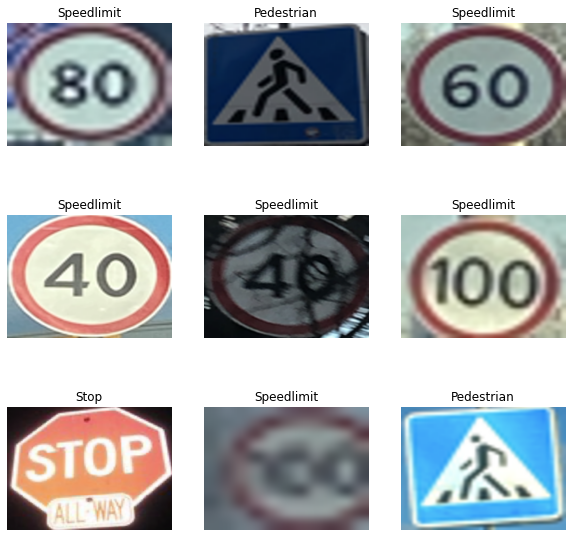

In [106]:
import matplotlib.pyplot as plt
# Checking the initial 9 images from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [107]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 300, 400, 3)
(16,)


In [108]:
# cache() and prefetch() ensures the dataset performance while loading it from the disk.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [109]:
# Normalizing the data
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.064542405 1.0


<h2> Generating The Model

1. A General Keras Model

In [110]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [111]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [113]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 400, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 200, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 100, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 100, 64)       1

**Training**

In [114]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
44/44 [==============================] - 26s 582ms/step - loss: 1.1416 - accuracy: 0.8291 - val_loss: 0.1035 - val_accuracy: 0.9600
Epoch 2/10
44/44 [==============================] - 25s 576ms/step - loss: 0.0528 - accuracy: 0.9843 - val_loss: 0.0313 - val_accuracy: 0.9829
Epoch 3/10
44/44 [==============================] - 25s 568ms/step - loss: 0.0108 - accuracy: 0.9986 - val_loss: 0.0279 - val_accuracy: 0.9829
Epoch 4/10
44/44 [==============================] - 25s 568ms/step - loss: 0.0068 - accuracy: 0.9972 - val_loss: 0.0481 - val_accuracy: 0.9829
Epoch 5/10
44/44 [==============================] - 26s 581ms/step - loss: 0.0741 - accuracy: 0.9858 - val_loss: 0.1185 - val_accuracy: 0.9543
Epoch 6/10
44/44 [==============================] - 26s 585ms/step - loss: 0.0412 - accuracy: 0.9858 - val_loss: 0.1074 - val_accuracy: 0.9714
Epoch 7/10
44/44 [==============================] - 26s 585ms/step - loss: 0.0218 - accuracy: 0.9972 - val_loss: 0.0442 - val_accuracy: 0.9829

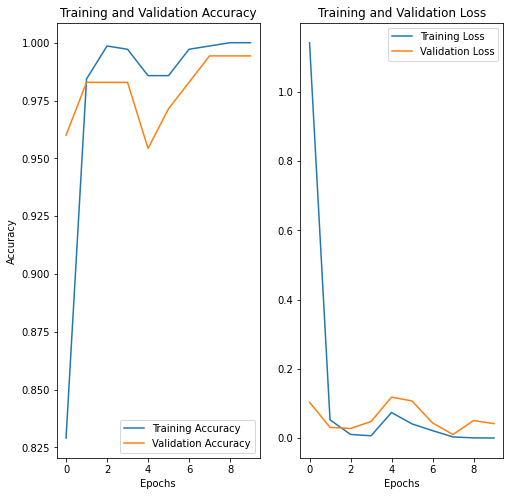

In [118]:
# Visualising the results obtained

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss')
plt.show()

*Adding Dropout to compensate overfitting*

In [119]:
# Applying data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [120]:
# Redefining the model
model_d = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [121]:
model_d.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [125]:
epochs = 8
history = model_d.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/8
44/44 [==============================] - 29s 653ms/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.0996 - val_accuracy: 0.9829
Epoch 2/8
44/44 [==============================] - 28s 630ms/step - loss: 0.0864 - accuracy: 0.9715 - val_loss: 0.1185 - val_accuracy: 0.9771
Epoch 3/8
44/44 [==============================] - 28s 630ms/step - loss: 0.0595 - accuracy: 0.9886 - val_loss: 0.0903 - val_accuracy: 0.9829
Epoch 4/8
44/44 [==============================] - 28s 636ms/step - loss: 0.0479 - accuracy: 0.9843 - val_loss: 0.1020 - val_accuracy: 0.9886
Epoch 5/8
44/44 [==============================] - 28s 642ms/step - loss: 0.0221 - accuracy: 0.9957 - val_loss: 0.0544 - val_accuracy: 0.9829
Epoch 6/8
44/44 [==============================] - 29s 667ms/step - loss: 0.0860 - accuracy: 0.9772 - val_loss: 0.0330 - val_accuracy: 0.9886
Epoch 7/8
44/44 [==============================] - 28s 629ms/step - loss: 0.0226 - accuracy: 0.9943 - val_loss: 0.1043 - val_accuracy: 0.9829
Epoch 

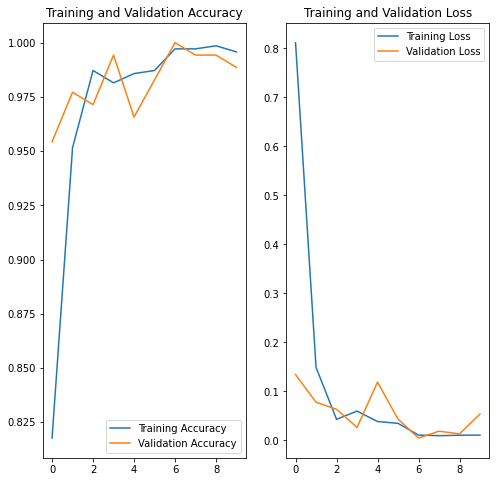

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()